### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import pickle

### Импорт данных

In [2]:
df_segmentation = pd.read_csv('segmentation data.csv', index_col = 0)

## Исследование данных

In [3]:
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [4]:
df_segmentation.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


## Оценка корреляции

In [5]:
df_segmentation.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


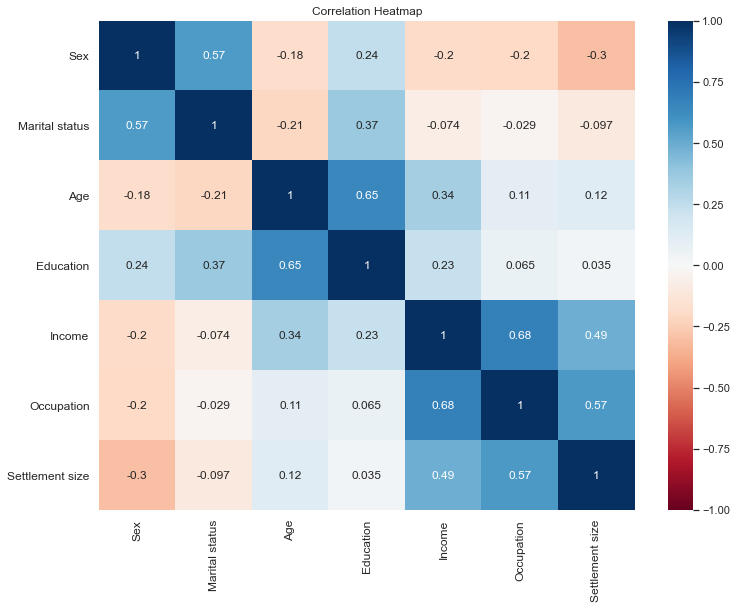

In [6]:
#Построим график Heatmap
plt.figure(figsize = (12, 9))
s = sns.heatmap(df_segmentation.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

## Визуализация зависимости между данными

<Figure size 1080x1080 with 0 Axes>

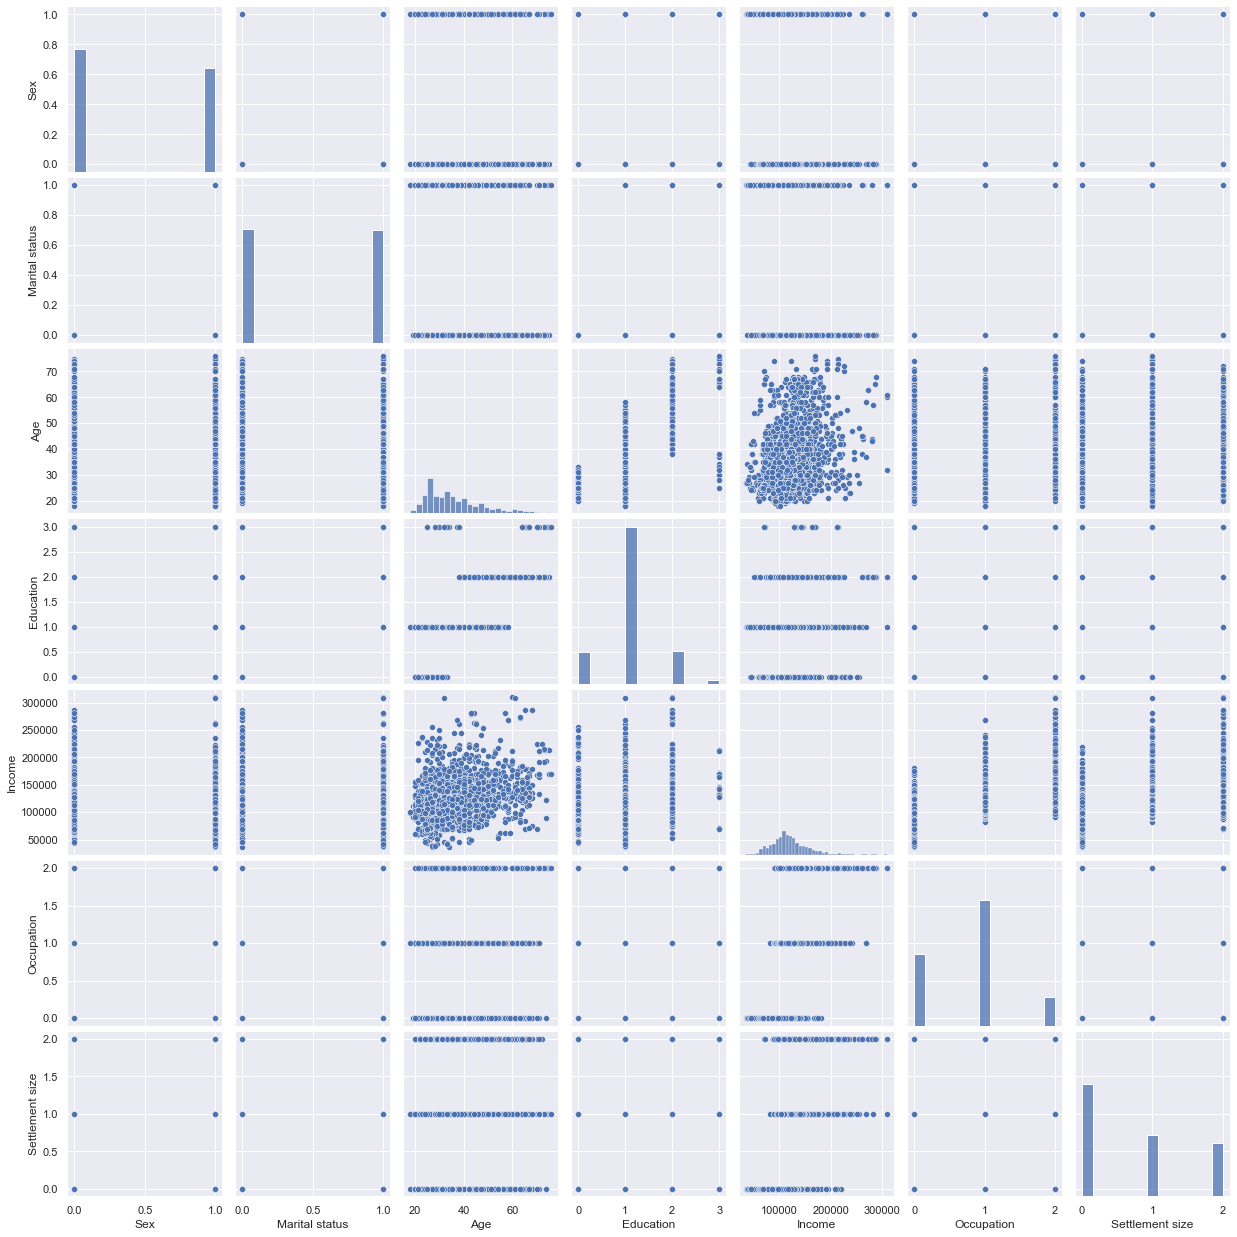

In [7]:
plt.figure(figsize = (15, 15))
g = sns.pairplot(df_segmentation)

И поближе рассмотрим график рассеяния Income - Age, дополнительно сгруппировав по роду деятельности


<AxesSubplot:xlabel='Income', ylabel='Age'>

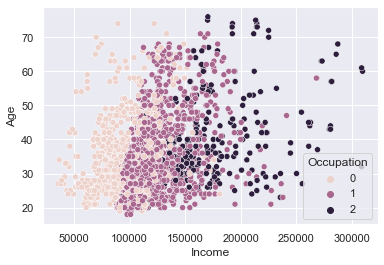

In [8]:
sns.scatterplot(x =df_segmentation.Income,
                y= df_segmentation.Age,
               hue = df_segmentation.Occupation)

## ${\textbf{Стандартизация}}$

In [9]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)

## ${\textbf{Иерархическая кластеризация}}$

In [10]:
hier_clust = linkage(segmentation_std, method = 'ward')

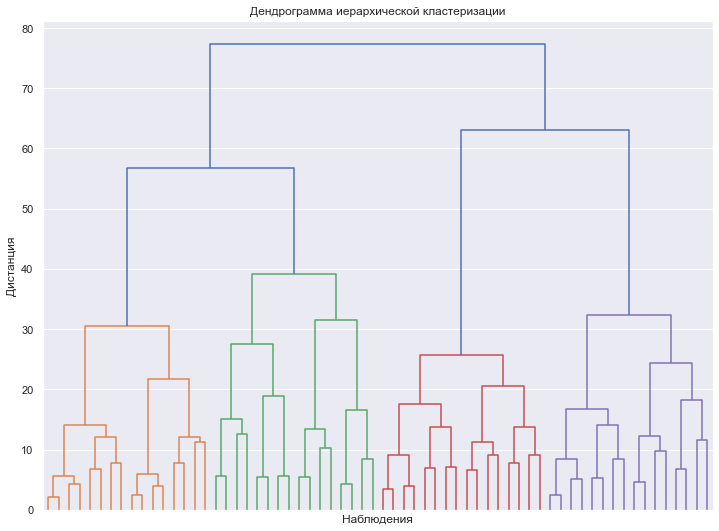

In [11]:
#Отобразим график построенной иерархии - Дендрограмму
plt.figure(figsize = (12,9))
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Наблюдения')
plt.ylabel('Дистанция')
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.show()

## ${\textbf{Кластеризация методом K-means }}$

Необходимо указать оптимальное число кластеров, которое будет ипользоваться в дальнейшей модели, для этого обучим модель несколько раз, указывая разное количество кластеров от одного до 10 и построим график значений WCSS (Сумма квадратов дистанций от центроида внутри кластера) в зависимости от числа кластеров

In [12]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

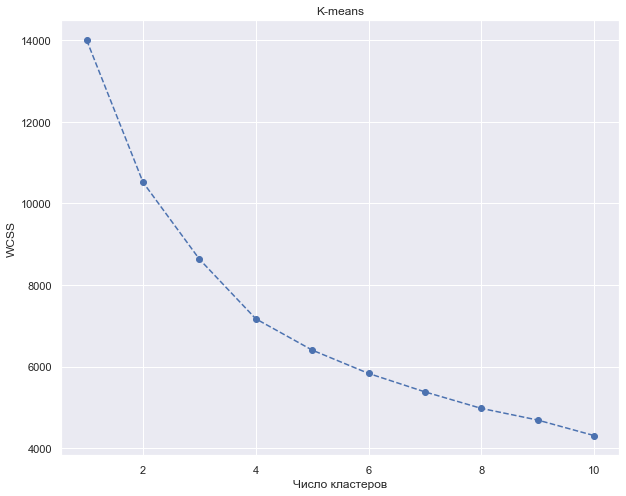

In [13]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.title('K-means')
plt.show()

Судя по графику, оптимальное число кластеров - 4, после данного значения показатель WCSS начинает падать медленнее

In [14]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [15]:
kmeans.fit(segmentation_std)

KMeans(n_clusters=4, random_state=42)

### ${\textbf{Результат}}$

In [16]:
df_segm_kmeans = df_segmentation.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [17]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695


In [18]:
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment K-means','Sex']].groupby(['Segment K-means']).count()
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()

In [19]:
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


- В нулевом сегменте почти одинаково представлены люди обоих полов, пожилого возраста, хорошо образованные и обладающие самым высоким доходом 
- Первый сегмент - Преимущественно одинокие люди около 36 лет с относительно низким доходом, из маленьких поселений. Часто не работающие и без всшего образования
- Второй сегмент - В подавляющем большинстве мужчины с работой и высоким доходом, из больших и средних городов, редко состоят в отношениях, и не имеющие высшего образования
- третьий сегмент - преимущественно замужние женщины, около 30 лет, с образованием, как работающие, так и не работающие и средним доходом относительно других сегментов, встречаются чаще всего

In [20]:

df_segm_analysis.rename({0:'well-off', #хорошо обеспеченные
                         1:'fewer-opportunities', #ограниченные в возможностях
                         2:'career focused', #карьеристы
                         3:'standard'}) #стандартные

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
fewer-opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
career focused,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


In [21]:
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'well-off', 
                                                                  1:'fewer opportunities',
                                                                  2:'career focused', 
                                                                  3:'standard'})

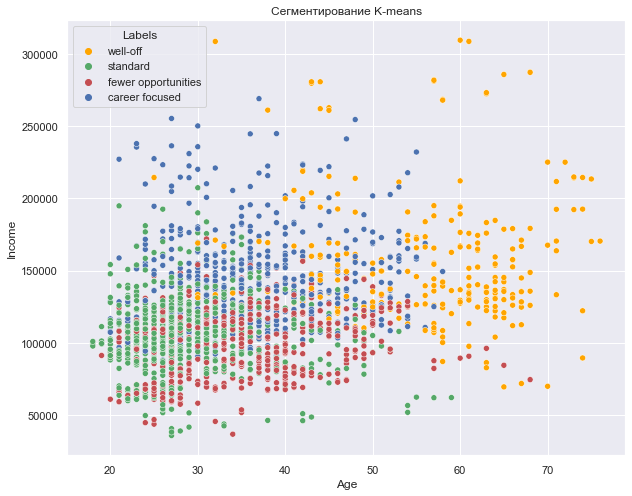

In [47]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x = df_segm_kmeans['Age'],
                y = df_segm_kmeans['Income'],
                hue = df_segm_kmeans['Labels'],
                palette = ['orange', 'g', 'r', 'b'])
plt.title('Сегментирование K-means')
plt.show()

### Применение метода главных компонент - PCA

In [23]:
pca = PCA()

In [24]:
pca.fit(segmentation_std)

PCA()

In [25]:
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

Text(0, 0.5, 'Совокупная доля от общей дисперсии')

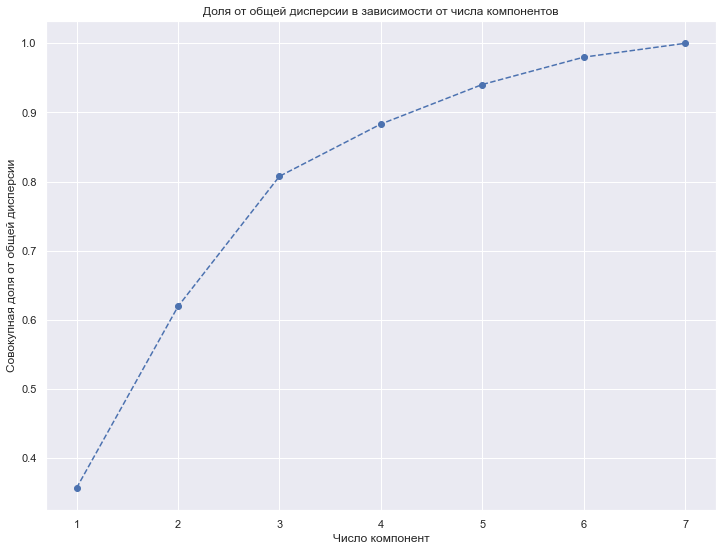

In [26]:
plt.figure(figsize = (12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Доля от общей дисперсии в зависимости от числа компонентов')
plt.xlabel('Число компонент')
plt.ylabel('Совокупная доля от общей дисперсии')

Здесь выбираем число компонентов, при котором покрывается значительная часть общей дисперсии и после которого совокупная доля растёт в меньшей степени
В данном случае 3 или 4 компонента будут оптимальны

In [27]:
pca = PCA(n_components = 4)

In [28]:
pca.fit(segmentation_std)

PCA(n_components=4)

### Результаты

In [29]:
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503],
       [-0.31560091,  0.28045392, -0.00950602,  0.18147643, -0.48260023,
        -0.28169039,  0.69026455]])

In [30]:
#Таблица завимимости признаков в исходном наборе и новых компонентов
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df_segmentation.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3', 'Component 4'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685
Component 4,-0.315601,0.280454,-0.009506,0.181476,-0.482600,-0.281690,0.690265


([<matplotlib.axis.YTick at 0x1ee7f330a60>,
 [Text(0, 0, 'Component 1'),
  Text(0, 1, 'Component 2'),
  Text(0, 2, 'Component 3'),
  Text(0, 3, 'Component 4')])

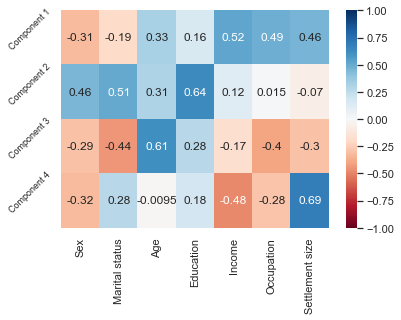

In [31]:
#Представим графически
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2, 3], 
           ['Component 1', 'Component 2', 'Component 3', 'Component 4'],
           rotation = 45,
           fontsize = 9)

In [32]:
pca.transform(segmentation_std)

array([[ 2.51474593,  0.83412239,  2.1748059 ,  1.21779432],
       [ 0.34493528,  0.59814564, -2.21160279,  0.54838542],
       [-0.65106267, -0.68009318,  2.2804186 ,  0.12067518],
       ...,
       [-1.45229829, -2.23593665,  0.89657125, -0.13177412],
       [-2.24145254,  0.62710847, -0.53045631, -0.04260559],
       [-1.86688505, -2.45467234,  0.66262172,  0.10089556]])

In [33]:
scores_pca = pca.transform(segmentation_std)

### Кластеризация методом K-Means с PCA

In [34]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

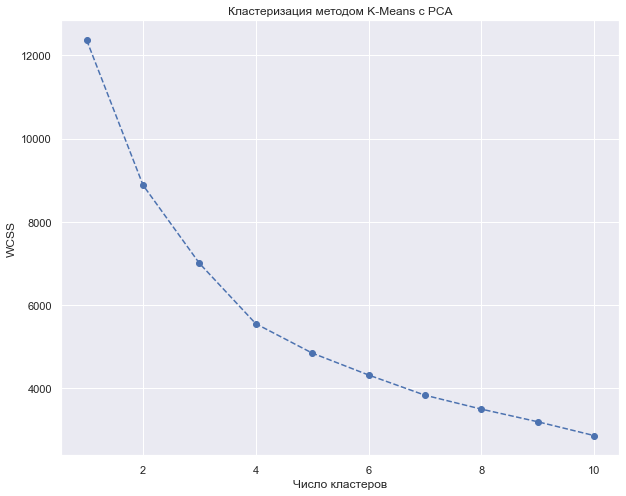

In [35]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Число кластеров')
plt.ylabel('WCSS')
plt.title('Кластеризация методом K-Means с PCA')
plt.show()

In [36]:
kmeans_pca = KMeans(n_clusters=4, init = "k-means++", random_state=42)

In [37]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [38]:
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop=True),
                               pd.DataFrame(scores_pca)], 
                              axis = 1)
df_segm_pca_kmeans.columns.values[-4:] = ['Component 1', 
                                         'Component 2',
                                         'Component 3',
                                         'Component 4']
df_segm_pca_kmeans['Segment K-Means PCA'] = kmeans_pca.labels_

In [39]:
df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Component 4,Segment K-Means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,1.217794,0
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0.548385,3
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,0.120675,2
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,-0.510753,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,-0.231808,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,-0.945916,2
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,-0.736766,3
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,-0.131774,2
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,-0.042606,3


In [40]:
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-Means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Component 4
Segment K-Means PCA,,,,,,,,,,,
0,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,0.093869
1,0.026178,0.178010,35.624782,0.734729,140950.319372,1.267016,1.520070,1.381089,-1.044848,-0.273292,0.211736
2,0.319018,0.089980,35.259714,0.768916,95850.155419,0.296524,0.038855,-0.987777,-0.882022,0.965476,-0.271684
3,0.905045,0.986647,28.873887,1.063798,107576.228487,0.672107,0.439169,-1.122432,0.733291,-0.797918,-0.019662


In [41]:
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-Means PCA','Sex']].groupby(['Segment K-Means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0: 'well-off',
                                                         1: 'career focused',
                                                         2: 'fewer opportunities',
                                                         3: 'standard'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Component 4,N Obs,Prop Obs
Segment K-Means PCA,,,,,,,,,,,,,
well-off,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,0.093869,264,0.1320
career focused,0.026178,0.178010,35.624782,0.734729,140950.319372,1.267016,1.520070,1.381089,-1.044848,-0.273292,0.211736,573,0.2865
fewer opportunities,0.319018,0.089980,35.259714,0.768916,95850.155419,0.296524,0.038855,-0.987777,-0.882022,0.965476,-0.271684,489,0.2445
standard,0.905045,0.986647,28.873887,1.063798,107576.228487,0.672107,0.439169,-1.122432,0.733291,-0.797918,-0.019662,674,0.3370


In [42]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-Means PCA'].map({0: 'well-off',
                                                         1: 'career focused',
                                                         2: 'fewer opportunities',
                                                         3: 'standard'})

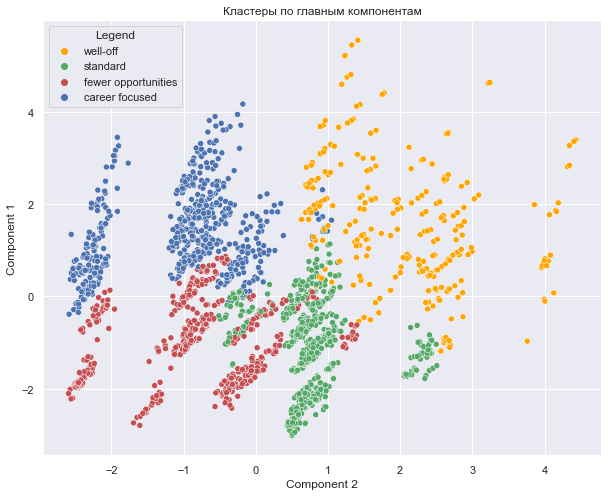

In [43]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x = df_segm_pca_kmeans['Component 2'],
                y = df_segm_pca_kmeans['Component 1'],
                hue = df_segm_pca_kmeans['Legend'],
                palette=['orange', 'g', 'r', 'b'])
plt.title('Кластеры по главным компонентам')
plt.show()

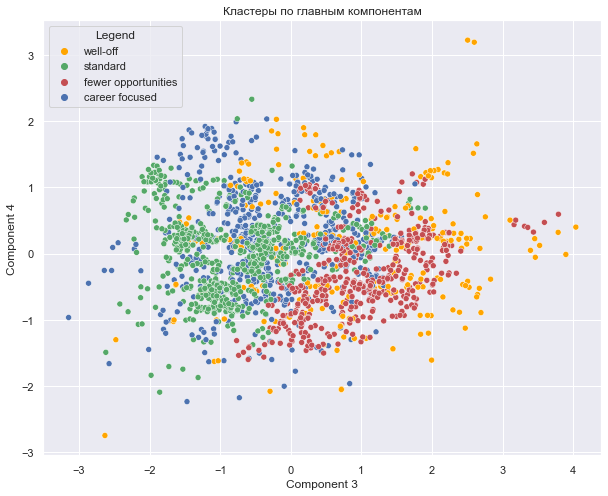

In [44]:
x_axis = df_segm_pca_kmeans['Component 3']
y_axis = df_segm_pca_kmeans['Component 4']

plt.figure(figsize=(10, 8))
sns.scatterplot(x = df_segm_pca_kmeans['Component 3'],
                y = df_segm_pca_kmeans['Component 4'],
                hue = df_segm_pca_kmeans['Legend'],
                palette=['orange', 'g', 'r', 'b'])
plt.title('Кластеры по главным компонентам')
plt.show()

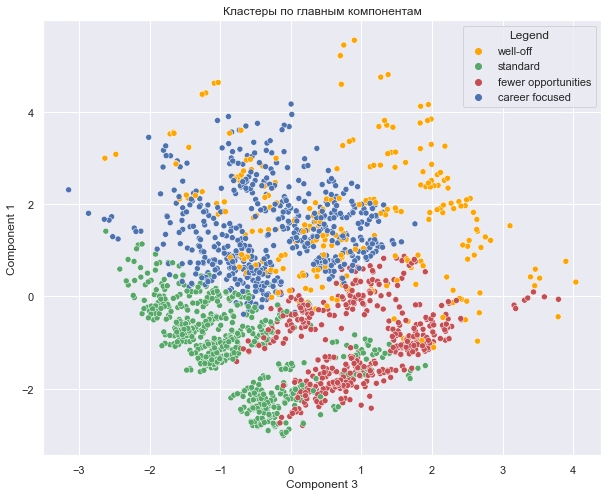

In [45]:
x_axis = df_segm_pca_kmeans['Component 3']
y_axis = df_segm_pca_kmeans['Component 1']

plt.figure(figsize=(10, 8))
sns.scatterplot(x = df_segm_pca_kmeans['Component 3'],
                y = df_segm_pca_kmeans['Component 1'],
                hue = df_segm_pca_kmeans['Legend'],
                palette=['orange', 'g', 'r', 'b'])
plt.title('Кластеры по главным компонентам')
plt.show()

### Экспорт данных

Сохраняем модели для стандартизации, выделения главных компонент и кластеризации в контейнеры pickle

In [46]:
pickle.dump(scaler, open('scaler.pickle', 'wb'))
pickle.dump(pca, open('pca.pickle', 'wb'))
pickle.dump(kmeans_pca, open('kmeans_pca.pickle', 'wb'))